<center>
<a href="https://colab.research.google.com/drive/1POL4Hjr-jATbmJLEhfGqcUhKNB6XYHHp?usp=sharing"> <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg"> </a></center>

## Importing Required Libraries

In [ ]:
from io import open
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


## Mounting G-Drive
You can skip this cell if you don't plan to save the model and training plots. For sampling, you can download the pre-trained model.

In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Fetching Data
Use `!wget -O your_file_name.extension raw_link`

To write contents from *raw_link* into *your_file_name.extension*.

In [ ]:
!wget -O Dino_Names.txt https://github.com/IvLabs/Natural-Language-Processing/raw/master/datasets/Dino_Names.txt

--2020-07-09 14:00:00--  https://github.com/IvLabs/Natural-Language-Processing/raw/master/datasets/Dino_Names.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IvLabs/Natural-Language-Processing/master/datasets/Dino_Names.txt [following]
--2020-07-09 14:00:01--  https://raw.githubusercontent.com/IvLabs/Natural-Language-Processing/master/datasets/Dino_Names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19909 (19K) [text/plain]
Saving to: ‘Dino_Names.txt’

Dino_Names.txt      100%[===================>]  19.44K  --.-KB/s    in 0.01s   

2020-07-09 14:00:01 (1.84 MB/s) - ‘Dino_Names.txt’ saved [1

## Data Preprocessing

In [ ]:
FILE_NAME = "Dino_Names.txt"
data = open(FILE_NAME).read().strip()
data = data.lower()
data = data.replace(" ", "")
data = data.replace("\n", ".")

In [ ]:
print(data[:50])

aachenosaurus.aardonyx.abdallahsaurus.abelisaurus.


In [ ]:
vocab = list(set(data))
vocab.sort()
print("Vocabulary: ", vocab)
print("Vocabulary Length: ", len(vocab))

Vocabulary:  ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary Length:  27


In [ ]:
char_idx = {c: i for i, c in enumerate(vocab)}
idx_char = {i: c for i, c in enumerate(vocab)}

In [ ]:
data = data.replace(".", " ")
data = data.split()
random.shuffle(data)

## Helper Functions

In [ ]:
def Split(corpus, valid_perc = 2, test_perc = 3):
    valid_split = int(len(corpus) * valid_perc / 100)
    test_split = int(len(corpus) * test_perc / 100)
    train_iterator = corpus[: -(valid_split + test_split)]
    test_iterator = corpus[-(valid_split + test_split): -valid_split]
    valid_iterator = corpus[-valid_split: ]

    return train_iterator, valid_iterator, test_iterator

In [ ]:
def InputTensor(x, vocab_size):
    ip_tensor = torch.zeros((len(x), vocab_size))           # [input_tensor] = [seq_len, vocab_size]
    for i in range(len(x)):
        letter = x[i]
        ip_tensor[i][char_idx[letter]] = 1
    
    return ip_tensor

In [ ]:
def TargetTensor(x):
    ids = [char_idx[letter] for letter in x[1:]]
    ids.append(char_idx['.'])
    target_tensor = torch.LongTensor(ids)                   # [target_tensor] = [seq_len]
    
    return target_tensor

In [ ]:
def Example(word, vocab_size):
    input_tensor = InputTensor(word, vocab_size)
    target_tensor = TargetTensor(word)
    
    return input_tensor, target_tensor

## Model Definition

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.25)
        # We do not use softmax as nn.CrossEntropyLoss() calculates both LogSoftmax and NLLLoss

    def forward(self, input, hidden):                       # [input] = [seq_len, batch_size, input_size]
        output, hidden = self.rnn(input, hidden)            # [output] = [seq_len, batch_size, hidden_size], [hiddden] = [seq_len, batch_size, hidden_size]
        output = self.fc(output)                            # [output] = [seq_len, batch_size, vocab_size]
        output = self.dropout(output)
        
        return output, hidden                               

    def initHidden(self):
        return torch.zeros((self.num_layers, 1, self.hidden_size))        # num_directions = batch_size = 1

## Training and Evaluation Functions

In [ ]:
def Train(iterator, model, criterion, optimizer):
    model.train()
    epoch_loss = 0
    for word in iterator:
        optimizer.zero_grad()
        input_tensor, target_tensor = Example(word, model.vocab_size)   # [input_tensor] = [seq_len, vocab_size]
        input_tensor = input_tensor.unsqueeze(1).to(device)             # [input_tensor] = [seq_len, 1, vocab_size] Since batch_size = 1 i.e. one word in a batch
        seq_len = input_tensor.shape[0]
        hidden = model.initHidden().to(device)
        outputs, _ = model(input_tensor, hidden)                        # [outputs] = [seq_len, batch_size, vocab_size], Here batch_size = 1
        outputs = outputs.view((-1, model.vocab_size))                  # [outputs] = [seq_len * batch_size, vocab_size] Since criterion requires outputs to be a 2D tensor
        batch_loss = criterion(outputs, target_tensor.to(device))       # [target_tensor] = [seq_len]
        epoch_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
    
    return epoch_loss / len(iterator)

In [ ]:
def Evaluate(iterator, model, criterion):
    model.eval()
    epoch_loss = 0
    for word in iterator:
        input_tensor, target_tensor = Example(word, model.vocab_size)
        seq_len = input_tensor.shape[0]
        input_tensor = input_tensor.unsqueeze(1).to(device)
        with torch.no_grad():
            hidden = model.initHidden().to(device)
            outputs, _ = model(input_tensor, hidden)
            outputs = outputs.view((-1, model.vocab_size))
            batch_loss = criterion(outputs, target_tensor.to(device))
            epoch_loss += batch_loss.item()
    
    return epoch_loss / len(iterator)

In [ ]:
def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

## Data Iterators, Hyperparameters and Model Initialization

In [ ]:
VALID_PERC = 2
TEST_PERC = 3
train_iterator, valid_iterator, test_iterator = Split(data, VALID_PERC, TEST_PERC)
print(f"Number of Training examples: {len(train_iterator)} | Number of Testing examples: {len(test_iterator)} | Number of Validation examples: {len(valid_iterator)}")

Number of Training examples: 1460 | Number of Testing examples: 46 | Number of Validation examples: 30


In [ ]:
NUM_EPOCHS = 40
LR = 4e-4
HIDDEN_DIM = 64
NUM_LAYERS = 1
VOCAB_SIZE = len(vocab)
MODEL_STORE_PATH = "/content/gdrive/My Drive/Colab/NLP/Char RNNs/Models/Dino_Names_RNN.pth"

In [ ]:
rnn = RNN(VOCAB_SIZE, HIDDEN_DIM, VOCAB_SIZE, NUM_LAYERS).to(device)
optimizer = optim.AdamW(rnn.parameters(), LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
total_params = sum(p.numel() for p in rnn.parameters())
total_learn_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params} | Total Learnable Parameters: {total_learn_params}")

Total Parameters: 7707 | Total Learnable Parameters: 7707


## Download Pre-Trained Model
Run this section instead of the "Training" section if you wish to download the pre-trained model instead of training one yourself.

In [ ]:
# !wget -O Dino_Names_RNN.pth https://gitlab.com/rishika2110/weights/-/blob/6e88f0c7acaf5d86d803eca8abb150e0b79f95ef/char_rnns/Dino_Names_RNN.pth

In [ ]:
# MODEL_STORE_PATH = "Dino_Names_RNN.pth"

## Training
Run this section only if you have mounted G-Drive and want to train the model yourself.

In [ ]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
prev_epoch = 1
min_losses = [float('inf'), float('inf')]
start_time = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss = Train(train_iterator, rnn, criterion, optimizer)
    train_losses.append(train_loss)
    valid_loss = Evaluate(valid_iterator, rnn, criterion)
    valid_losses.append(valid_loss)
    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(rnn.state_dict(), MODEL_STORE_PATH)
    if epoch % int(NUM_EPOCHS / 10) == 0:
        elapsed_time = Epoch_time(start_time, time.time())
        print(f"Time taken for epochs {prev_epoch} to {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
        start_time = time.time()
        prev_epoch = epoch + 1
        print(f"Training Loss: {train_losses[epoch - 1]:.4f} | Valid Loss: {valid_losses[epoch - 1]:.4f}")
print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.0004, Hidden Dimensions: 64
Time taken for epochs 1 to 4: 0m 22s
Training Loss: 2.1505 | Valid Loss: 1.9599
Time taken for epochs 5 to 8: 0m 22s
Training Loss: 2.0623 | Valid Loss: 1.8748
Time taken for epochs 9 to 12: 0m 21s
Training Loss: 2.0095 | Valid Loss: 1.8225
Time taken for epochs 13 to 16: 0m 21s
Training Loss: 1.9609 | Valid Loss: 1.7797
Time taken for epochs 17 to 20: 0m 22s
Training Loss: 1.9335 | Valid Loss: 1.7526
Time taken for epochs 21 to 24: 0m 21s
Training Loss: 1.9139 | Valid Loss: 1.7301
Time taken for epochs 25 to 28: 0m 21s
Training Loss: 1.9014 | Valid Loss: 1.7128
Time taken for epochs 29 to 32: 0m 21s
Training Loss: 1.8649 | Valid Loss: 1.7060
Time taken for epochs 33 to 36: 0m 21s
Training Loss: 1.8576 | Valid Loss: 1.6835
Time taken for epochs 37 to 40: 0m 21s
Training Loss: 1.8402 | Valid Loss: 1.6860
Model with Train Loss 1.8576, Validation Loss: 1.6835 was saved.


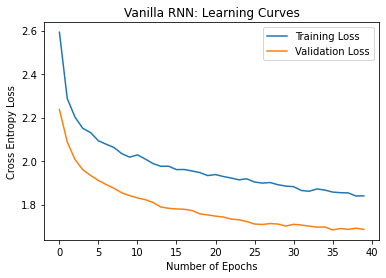

In [ ]:
plt.title("Vanilla RNN: Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.legend()
plt.savefig("/content/gdrive/My Drive/Colab/NLP/Char RNNs/Plots/Dino_Names_RNN.jpeg")
plt.show()

## Sampling

In [ ]:
max_length = 20

def sample(start_letter, model):
    with torch.no_grad():
        start_letter = start_letter.lower()
        input = InputTensor(start_letter, model.vocab_size)                             # [input] = [1, vocab_size]
        hidden = model.initHidden()
        output_name = str(start_letter)
        for i in range(max_length):
            output, hidden = model(input.unsqueeze(0).to(device), hidden.to(device))    # [output] = [1, 1, vocab_size], [hidden] = [1, 1, hidden_size]
            output = output.squeeze(1)                                                  # [output] = [1, vocab_size]
            probs = F.softmax(output, dim = 1)
            ind = probs.argmax(1).item()
            if ind == char_idx["."]:
                break
            else:
                letter = idx_char[ind]
                output_name += letter
            input = InputTensor(letter, model.vocab_size)

        return output_name

In [ ]:
def samples(start_letters, model):
    for start_letter in start_letters:
        print(f"Starting character: {start_letter} -> Dino name: {sample(start_letter, model)}")

In [ ]:
rnn.load_state_dict(torch.load(MODEL_STORE_PATH))
rnn.eval()
print(f"Test Loss of Loaded Model: {Evaluate(test_iterator, rnn, criterion)}")
samples("ABCDEFGHIJKLMNOPQRSTUVWXYZ", rnn)

Test Loss of Loaded Model: 1.5293632914190707
Starting character: A -> Dino name: alasaurus
Starting character: B -> Dino name: baratosaurus
Starting character: C -> Dino name: chenosaurus
Starting character: D -> Dino name: donosaurus
Starting character: E -> Dino name: eratosaurus
Starting character: F -> Dino name: fusanosaurus
Starting character: G -> Dino name: gongosaurus
Starting character: H -> Dino name: hangongosaurus
Starting character: I -> Dino name: iangosaurus
Starting character: J -> Dino name: jiangosaurus
Starting character: K -> Dino name: kuranosaurus
Starting character: L -> Dino name: lophodon
Starting character: M -> Dino name: marasaurus
Starting character: N -> Dino name: notorantos
Starting character: O -> Dino name: ornithosaurus
Starting character: P -> Dino name: palarosaurus
Starting character: Q -> Dino name: quangongosaurus
Starting character: R -> Dino name: raptoroptor
Starting character: S -> Dino name: sauropelta
Starting character: T -> Dino name: t